# Multi-Layer Perceptron Neural Network for Infant Mortality Classification

Note:

- Death cases: infant_mortality == 1
- Survived cases: infant_mortality == 0

# Importing data

In [1]:
import pandas as pd
import numpy as np
df_test = pd.read_csv('https://media.githubusercontent.com/media/leahhkim/final_project_analyticsII/refs/heads/main/Data/nvss_test.csv', low_memory=False)
df_train = pd.read_csv('https://media.githubusercontent.com/media/leahhkim/final_project_analyticsII/refs/heads/main/Data/nvss_train.csv', low_memory=False)
df_val = pd.read_csv('https://media.githubusercontent.com/media/leahhkim/final_project_analyticsII/refs/heads/main/Data/nvss_val.csv', low_memory=False)

df_train.head()

,mager14,mar,meduc,mbrace,umhisp,lbo,tbo,precare_rec,previs_rec,wtgain_rec,...,ca_menin,ca_heart,ca_ompha,ca_gastro,ca_limb,ca_cleftlp,ca_cleft,ca_downs,ca_chrom,infant_death
0,10,2,3.0,2.0,0,3,3,1.0,8,4,...,0,0,0,0,0,0,0,1,1,0
1,10,1,7.0,2.0,0,2,2,1.0,8,4,...,0,0,0,0,0,0,0,1,1,0
2,11,1,3.0,1.0,0,4,7,1.0,8,3,...,0,0,0,0,0,0,0,1,1,0
3,8,2,3.0,2.0,0,2,2,3.0,3,4,...,0,0,0,0,0,0,0,1,1,0
4,11,1,3.0,1.0,1,2,3,1.0,5,4,...,0,0,0,0,0,0,0,1,1,0


### Building Features and creating tensors

In [17]:
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import TensorDataset, DataLoader

target_col = "infant_death"

# Drop the target column from the feature dataset
X_train = df_train.drop(columns=[target_col]).values.astype("float32")
y_train = df_train[target_col].values.astype("float32")

X_val = df_val.drop(columns=[target_col]).values.astype("float32")
y_val = df_val[target_col].values.astype("float32")

X_test = df_test.drop(columns=[target_col]).values.astype("float32")
y_test = df_test[target_col].values.astype("float32")

print("X_train shape:", X_train.shape)

# how many deaths occur in the dataset
print("Positive death rate in train set:", y_train.mean())

# standardization of all three datasets
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)


# use GPU to accelerate training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# converting to tensors
X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
y_train_t = torch.tensor(y_train, dtype=torch.float32).to(device)

X_val_t = torch.tensor(X_val_scaled, dtype=torch.float32).to(device)
y_val_t = torch.tensor(y_val, dtype=torch.float32).to(device)

X_test_t = torch.tensor(X_test_scaled,dtype=torch.float32).to(device)
y_test_t = torch.tensor(y_test,dtype=torch.float32).to(device)

batch_size = 1024

# creating data loaders for each dataset
train_ds = TensorDataset(X_train_t, y_train_t)
val_ds = TensorDataset(X_val_t,   y_val_t)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)


X_train shape: (2138649, 38)
Positive death rate in train set: 0.0058616446
Using device: cuda:0


The positive death rate tells us that only 0.6% of the cases in the training set has an outcome of death as the target variable. This meant that we need to apply more weight to the positive case (the death case) in our neural network training to ensure that the network does not overfit negative cases and ignore positive cases.

### Examining test and validation case positive weight

In [20]:
print("Positive death rate in test set:", y_test.mean())
print("Positive death rate in validation set:", y_val.mean())

Positive death rate in test set: 0.005862104
Positive death rate in validation set: 0.005862104


### Creating the model

In [8]:
import torch.nn as nn
import torch.optim as optim

# defining a multi-layer perceptron model for binary classification
class MLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            # first hidden layer
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64), # normalize the 64 activations to stabilize training
            nn.Dropout(0.2), # randomly drop 20% of neurons to regularize model and reduce overfitting

            # second hidden layer
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Dropout(0.2),

            # third hidden layer
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.BatchNorm1d(16),
            nn.Dropout(0.2),

            # output layer
            nn.Linear(16, 1)
        )

    # defining the forward propagation function
    def forward(self, x):
        return self.net(x).squeeze(1)  # shape (batch,)

# retrieve input features from training tensor
input_dim = X_train_t.shape[1]
# create an instance of the model in GPU
model = MLP(input_dim).to(device)
print(model)


MLP(
  (net): Sequential(
    (0): Linear(in_features=38, out_features=64, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=32, out_features=16, bias=True)
    (9): ReLU()
    (10): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.2, inplace=False)
    (12): Linear(in_features=16, out_features=1, bias=True)
  )
)


# Defining the training strategy
- implementing validation set to evaluate training loss during the training process
- implementing an early stopping mechanism to ensure that the model does not overfit and train on endlessly
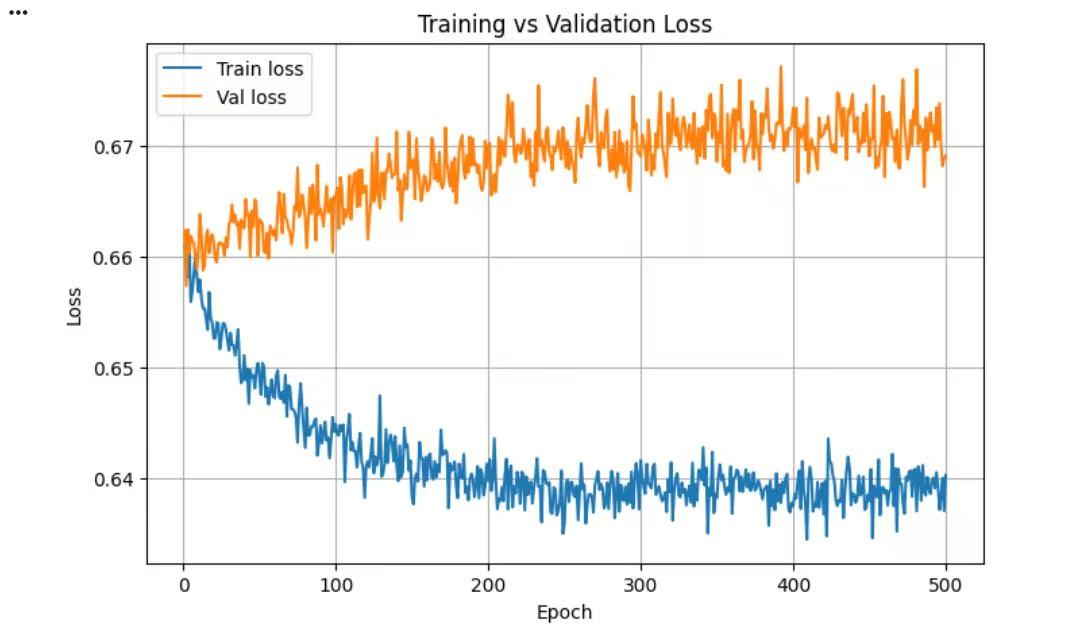

- Optimize the model by completing a grid search over a list of learning rates


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# creating an optimized neural network model via performing simple grid search over learning rates
#

def train_one_lr(lr_value):
    # build a new model for each input learning rate
    input_dim = X_train_t.shape[1]
    model = MLP(input_dim).to(device)

    # defining a positive class weight to add more weight to death cases
    # infant_death == 1
    n_pos = y_train.sum()
    n_neg = len(y_train) - n_pos
    pos_weight_value = n_neg / n_pos
    pos_weight = torch.tensor([pos_weight_value], dtype=torch.float32).to(device)

    # defining the loss function for binary classification, applying extra weight on positive class
    # as positive classes (death cases) are rare in the data set
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    # using adam optimizer with the given learning rate
    optimizer = optim.Adam(model.parameters(), lr=lr_value)

    # maximum train for 200 epochs
    num_epochs = 200
    best_val_loss = float("inf")
    best_state_dict = None

    # parameters for early stopping mechanisms
    wait_epoch = 30
    # wait_epoch = 60
    no_improve = 0

    train_losses = []
    val_losses = []

    # train and document train and validation losses for each epoch
    for epoch in range(1, num_epochs + 1):
        model.train()
        train_loss_sum = 0.0

        # defining a one full pass over the training data
        for xb, yb in train_loader:
            xb = xb.to(device)
            yb = yb.to(device)

            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()

            # add up total loss for every training sample
            train_loss_sum += loss.item() * xb.size(0)

        # calculate average training loss across all training samples
        train_loss = train_loss_sum / len(train_loader.dataset)

        # evaluate the validation set
        model.eval()
        with torch.no_grad():
            val_logits = model(X_val_t.to(device))
            val_loss = criterion(val_logits, y_val_t.to(device)).item()

        # save training and validation loss
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # check if this is hte best validation loss so far with a small tolerance
        if val_loss < best_val_loss - 1e-4:
            best_val_loss = val_loss
            best_state_dict = model.state_dict()
            no_improve = 0
        else:
            no_improve += 1

        # print every 10 epochs (and the first epoch)
        if epoch % 10 == 0 or epoch == 1:
            print(f"Epoch {epoch:03d} | lr={lr_value:.1e} | train={train_loss:.4f} | val={val_loss:.4f} | no_improve={no_improve}")

        # stop the training early if validation loss does not get improved over 30 epochs
        if no_improve >= wait_epoch:
            print(f"Early stopping for lr={lr_value:.1e} at epoch {epoch}")
            break
    # return best validation loss, best model parameters, and learning rate used
    return best_val_loss, best_state_dict, lr_value

# set of learning rates to test on
lr_list = [5e-4, 1e-3, 1e-4]
# lr_list = [1e-4, 3e-4, 5e-4, 1e-3, 3e-3]
results = []

# train a separate model for each learning rate and record how well it did
for lr in lr_list:
    best_loss, best_state, lr_used = train_one_lr(lr)
    results.append((best_loss, lr_used, best_state))

# pick best learning rate that had the lowest validation lost
results.sort(key=lambda x: x[0])
best_val_loss, best_lr, best_state_dict = results[0]

print("\nbest learning rate result")
print(f"Best lr={best_lr:.1e} with val_loss={best_val_loss:.4f}")

# load best model into a fresh instance for final use
model = MLP(X_train_t.shape[1]).to(device)
model.load_state_dict(best_state_dict)
torch.save(best_state_dict, "best_mlp_infant_mortality.pt")
print("Saved best model to best_mlp_infant_mortality.pt")


Epoch 001 | lr=5.0e-04 | train=0.7908 | val=0.6817 | no_improve=0
Epoch 010 | lr=5.0e-04 | train=0.6674 | val=0.6626 | no_improve=1
Epoch 020 | lr=5.0e-04 | train=0.6582 | val=0.6608 | no_improve=5
Epoch 030 | lr=5.0e-04 | train=0.6509 | val=0.6597 | no_improve=15
Epoch 040 | lr=5.0e-04 | train=0.6466 | val=0.6623 | no_improve=25
Early stopping for lr=5.0e-04 at epoch 45
Epoch 001 | lr=1.0e-03 | train=0.7400 | val=0.6757 | no_improve=0
Epoch 010 | lr=1.0e-03 | train=0.6637 | val=0.6634 | no_improve=1
Epoch 020 | lr=1.0e-03 | train=0.6532 | val=0.6629 | no_improve=5
Epoch 030 | lr=1.0e-03 | train=0.6484 | val=0.6608 | no_improve=3
Epoch 040 | lr=1.0e-03 | train=0.6487 | val=0.6660 | no_improve=13
Epoch 050 | lr=1.0e-03 | train=0.6428 | val=0.6682 | no_improve=23
Early stopping for lr=1.0e-03 at epoch 57
Epoch 001 | lr=1.0e-04 | train=0.9794 | val=0.8036 | no_improve=0
Epoch 010 | lr=1.0e-04 | train=0.6869 | val=0.6709 | no_improve=1
Epoch 020 | lr=1.0e-04 | train=0.6713 | val=0.6654 | n

### Computing evaluation metrics
- accuracy score
- positive case recall score
- roc_auc
- average precision score

In [21]:
from sklearn.metrics import roc_auc_score, average_precision_score

model.eval()

# turning off gradient tracking for model inference purposes
with torch.no_grad():

    # extracting raw model scores for test cases
    logits_test = model(X_test_t)
    # convert model scores (or logits) to probabilities between 0 and 1
    probs_test = torch.sigmoid(logits_test)
    # turn probabilities to label classifications, classifying death if >= 0.5, else survival
    preds_test = (probs_test >= 0.5).float()

# convert tensors back into cpu and into numpy arrays for metric calculation
y_test_result = y_test_t.cpu().numpy()
probs_test_result = probs_test.cpu().numpy()
preds_test_result = preds_test.cpu().numpy()

# defining four metrics to evaluate model performance
test_acc = (preds_test_result == y_test_result).mean()
test_recall_pos = (
    (preds_test_result[y_test_result == 1] == 1).mean()
    if (y_test_result == 1).sum() > 0
    else float("nan")
)
test_auc = roc_auc_score(y_test_result, probs_test_result)
test_ap  = average_precision_score(y_test_result, probs_test_result)

# How many test cases the model got right overall
print("Test accuracy:", test_acc)

# Out of all babies who actually died, what fraction the model correctly flagged as death
print("Test accuracy for infant_death=1:", test_recall_pos)

# How often the model gives a higher risk score to a baby who died than to a baby who survived
print("Test ROC-AUC:", test_auc)

# When we sort babies from highest to lowest risk,
# how well the model puts real deaths near the top of the list instead of survivors
print("Test PR-AUC:", test_ap)


Test accuracy: 0.9265434488640508
Test accuracy for infant_death=1: 0.7755443886097152
Test ROC-AUC: 0.9223098418023772
Test PR-AUC: 0.4932807186704762


According to the current results, we could see that the model:
- predicts test cases in general really well with 93% accuracy, meaning that the model correctly classified about 93% of the test cases. However, this could be skewed due to how the dataset itself contains a majority of survival cases of infants, with only 0.6% of the cases are actual death cases, hence it is naturally easy for the model to classify these cases at a high
- predicts well among the test cases where the baby actually died, with a 78% accuracy.
- allocates an apprioriate high risk score to babies who died compared to cases where the baby survived in 92% of the time
- appropriately sorts high risk baby cases at the top with low risk baby cases at the bottom (those who survived), rather than randomly sorting those cases with survivors. The accuracy level is about 49%, which is relatively higher than expected considering we only have 0.6% of the cases that are death cases.

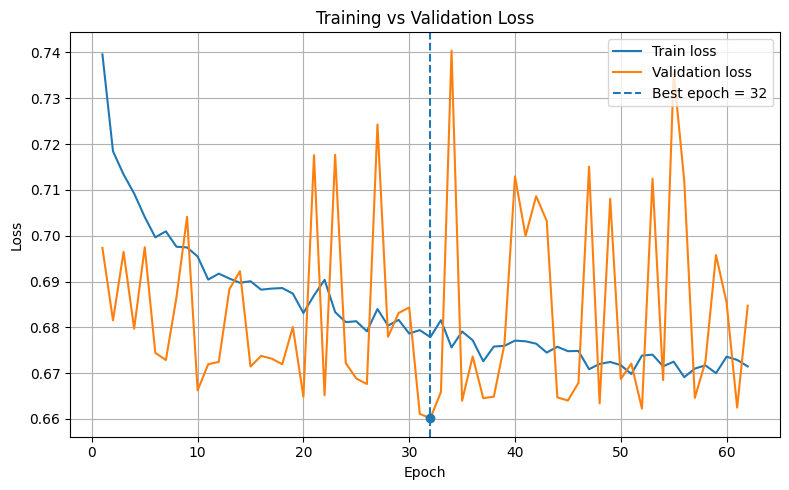

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# epochs actually run (in case of early stopping)
epochs = range(1, len(train_losses) + 1)

# find best epoch by lowest validation loss
best_epoch = 1 + int(np.argmin(val_losses))
best_val = val_losses[best_epoch - 1]

plt.figure(figsize=(8, 5))
plt.plot(epochs, train_losses, label="Train loss")
plt.plot(epochs, val_losses, label="Validation loss")
plt.axvline(best_epoch, linestyle="--", label=f"Best epoch = {best_epoch}")
plt.scatter([best_epoch], [best_val], zorder=5)

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


As we could see, the training loss was able to steadily decrease up until a point where validation loss no longer seems to improve, however the best model still lives at 32 epochs